<a href="https://colab.research.google.com/github/jaydenchoe/Fundamentals-of-Deep-Learning-Book/blob/master/ch13_deep_reinforcement_learning/Ch13_01_RL_Pole_Cart.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Markov Decision Processes (MDP)
## Future Return

In [1]:
import numpy as np
# numpy 2.x compatibility for gym expecting np.bool8
if not hasattr(np, 'bool8'):
    np.bool8 = np.bool_
import random
import gym
import tqdm
import torch
import torch.nn as nn

# for reproductability
torch.manual_seed(0)
random.seed(0)

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=

In [2]:
def calculate_naive_returns(rewards):
    """ Calculates a list of naive returns given a
    list of rewards."""
    total_returns = np.zeros(len(rewards))
    total_return = 0.0
    for t in range(len(rewards), 0):
        total_return = total_return + reward
        total_returns[t] = total_return
    return total_returns


def discount_rewards(rewards, gamma=0.98):
    discounted_returns = [0 for _ in rewards]
    discounted_returns[-1] = rewards[-1]
    # iterate backwards
    for t in range(len(rewards)-2, -1, -1):
        discounted_returns[t] = (rewards[t] +
              discounted_returns[t+1]*gamma)
    return discounted_returns

def epsilon_greedy_action(action_distribution,
                          epsilon=1e-1):
    action_distribution = action_distribution.detach().numpy()
    if random.random() < epsilon:
        return np.argmax(np.random.random(
           action_distribution.shape))
    else:
        return np.argmax(action_distribution)

def epsilon_greedy_action_annealed(action_distribution,
                                   percentage,
                                   epsilon_start=1.0,
                                   epsilon_end=1e-2):
    action_distribution = action_distribution.detach().numpy()
    annealed_epsilon = (epsilon_start*(1.0-percentage) +
                        epsilon_end*percentage)
    if random.random() < annealed_epsilon:
        return np.argmax(np.random.random(
          action_distribution.shape))
    else:
        return np.argmax(action_distribution)

# Pole-Cart with Policy Gradients

## Creating an Agent

In [3]:
from torch import optim
class PGAgent(object):
    def __init__(self, state_size, num_actions,
                 hidden_size,
                 learning_rate=1e-3,
                 explore_exploit_setting= \
                 'epsilon_greedy_annealed_1.0->0.001'):
        self.state_size = state_size
        self.num_actions = num_actions
        self.hidden_size = hidden_size
        self.learning_rate = learning_rate
        self.explore_exploit_setting = \
                        explore_exploit_setting
        self.build_model()


    def build_model(self):
      self.model = torch.nn.Sequential(
        nn.Linear(self.state_size, self.hidden_size),
        nn.Linear(self.hidden_size, self.hidden_size),
        nn.Linear(self.hidden_size, self.num_actions),
        nn.Softmax(dim=0))

    def train(self, state, action_input, reward_input):
        state = torch.tensor(state).float()
        action_input = torch.tensor(action_input).long()
        reward_input = torch.tensor(reward_input).float()
        self.output = self.model(state)
        # Select the logits related to the action taken
        logits_for_actions = self.output.gather(1,action_input.view(-1,1))

        self.loss = -torch.mean(
            torch.log(logits_for_actions) * reward_input)
        self.loss.backward()
        self.optimizer = optim.Adam(self.model.parameters())
        self.optimizer.step()
        self.optimizer.zero_grad()
        return self.loss.item()



    def sample_action_from_distribution(self,
                                        action_distribution,
                                        epsilon_percentage):
        # Choose an action based on the action probability
        # distribution and an explore vs exploit
        if self.explore_exploit_setting == 'greedy':
              action = epsilon_greedy_action(action_distribution,0.00)
        elif self.explore_exploit_setting == 'epsilon_greedy_0.05':
              action = epsilon_greedy_action(action_distribution,0.05)
        elif self.explore_exploit_setting == 'epsilon_greedy_0.25':
              action = epsilon_greedy_action(action_distribution,0.25)
        elif self.explore_exploit_setting == 'epsilon_greedy_0.50':
              action = epsilon_greedy_action(action_distribution,0.50)
        elif self.explore_exploit_setting == 'epsilon_greedy_0.90':
              action = epsilon_greedy_action(action_distribution,0.90)
        elif self.explore_exploit_setting == \
          'epsilon_greedy_annealed_1.0->0.001':
              action = epsilon_greedy_action_annealed(
                  action_distribution,
                  epsilon_percentage, 1.0,0.001)
        elif self.explore_exploit_setting == \
          'epsilon_greedy_annealed_0.5->0.001':
              action = epsilon_greedy_action_annealed(
                  action_distribution,
                  epsilon_percentage, 0.5, 0.001)
        elif self.explore_exploit_setting == \
          'epsilon_greedy_annealed_0.25->0.001':
              action = epsilon_greedy_action_annealed(
                  action_distribution,
                  epsilon_percentage, 0.25, 0.001)
        return action

    def predict_action(self, state, epsilon_percentage):
        action_distribution = self.model(torch.from_numpy(state).float())
        action = self.sample_action_from_distribution(
            action_distribution, epsilon_percentage)
        return action

## Keeping Track of History

In [4]:
class EpisodeHistory(object):

    def __init__(self):
        self.states = []
        self.actions = []
        self.rewards = []
        self.state_primes = []
        self.discounted_returns = []

    def add_to_history(self, state, action, reward,
      state_prime):
        self.states.append(state)
        self.actions.append(action)
        self.rewards.append(reward)
        self.state_primes.append(state_prime)


class Memory(object):

    def __init__(self):
        self.states = []
        self.actions = []
        self.rewards = []
        self.state_primes = []
        self.discounted_returns = []

    def reset_memory(self):
        self.states = []
        self.actions = []
        self.rewards = []
        self.state_primes = []
        self.discounted_returns = []

    def add_episode(self, episode):
        self.states += episode.states
        self.actions += episode.actions
        self.rewards += episode.rewards
        self.discounted_returns += episode.discounted_returns

## Policy Gradient Main Function

In [5]:
# Configure Settings
#total_episodes = 5000
total_episodes = 16
total_steps_max = 10000
epsilon_stop = 3000
train_frequency = 8
max_episode_length = 500
render_start = -1
should_render = False

explore_exploit_setting = 'epsilon_greedy_annealed_1.0->0.001'

env = gym.make('CartPole-v0')
state_size = env.observation_space.shape[0]  # 4 for
                                              # CartPole-v0
num_actions = env.action_space.n  # 2 for CartPole-v0

solved = False
agent = PGAgent(state_size=state_size,
                num_actions=num_actions,
                hidden_size=16,
                explore_exploit_setting= \
                  explore_exploit_setting)

/usr/local/lib/python3.12/dist-packages/gym/envs/registration.py:593: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(
/usr/local/lib/python3.12/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.12/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [6]:
episode_rewards = []
batch_losses = []

global_memory = Memory()
steps = 0
for i in range(total_episodes):
  state = env.reset()
  episode_reward = 0.0
  episode_history = EpisodeHistory()
  epsilon_percentage = float(min(i/float(epsilon_stop), 1.0))

  for j in range(max_episode_length):
      action = agent.predict_action(state, epsilon_percentage)
      state_prime, reward, terminal, _ = env.step(action)

      episode_history.add_to_history(
          state, action, reward, state_prime)
      state = state_prime
      episode_reward += reward
      steps += 1

      if j == (max_episode_length - 1):
            terminal = True

      if terminal:
          episode_history.discounted_returns = \
            discount_rewards(episode_history.rewards)
          global_memory.add_episode(episode_history)

          # every 8th episode train the NN
          # train on all actions from episodes in memory, then reset memory
          if np.mod(i, train_frequency) == 0:
            reward_input = global_memory.discounted_returns
            action_input = global_memory.actions
            state = global_memory.states

            # train step
            batch_loss = agent.train(state, action_input, reward_input)
              # print(f'Batch loss: {batch_loss}')
              # batch_losses.append(batch_loss)
            global_memory.reset_memory()

          episode_rewards.append(episode_reward)

          if i % 10 == 0:
              mean_rewards = torch.mean(torch.tensor(episode_rewards[:-10]))
              if mean_rewards > 10.0:
                  solved = True
              else:
                  solved = False
              print(f'Solved: {solved} Mean Reward: {mean_rewards}')
          break # stop playing if terminal

  print(f'Episode[{i}]: {len(episode_history.actions)} \
          actions {episode_reward} reward')

/tmp/ipython-input-1637880809.py:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:253.)
  state = torch.tensor(state).float()


Solved: False Mean Reward: nan
Episode[0]: 28           actions 28.0 reward
Episode[1]: 65           actions 65.0 reward
Episode[2]: 14           actions 14.0 reward
Episode[3]: 30           actions 30.0 reward
Episode[4]: 30           actions 30.0 reward
Episode[5]: 13           actions 13.0 reward
Episode[6]: 26           actions 26.0 reward
Episode[7]: 16           actions 16.0 reward
Episode[8]: 34           actions 34.0 reward
Episode[9]: 17           actions 17.0 reward
Solved: True Mean Reward: 28.0
Episode[10]: 25           actions 25.0 reward
Episode[11]: 45           actions 45.0 reward
Episode[12]: 25           actions 25.0 reward
Episode[13]: 34           actions 34.0 reward
Episode[14]: 10           actions 10.0 reward
Episode[15]: 29           actions 29.0 reward


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


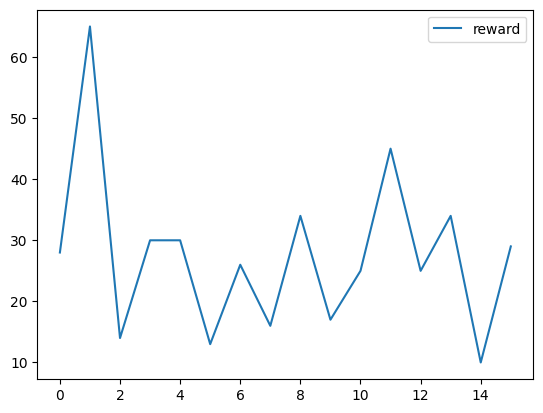

Demo return: 13.0


In [46]:
# 보상 곡선 + 1에피소드 데모
import matplotlib.pyplot as plt, numpy as np, torch

plt.plot(episode_rewards, label='reward')
if len(episode_rewards) >= 20:
    ma = np.convolve(episode_rewards, np.ones(20)/20, 'valid')
    plt.plot(range(19,19+len(ma)), ma, label='MA(20)')
plt.legend(); plt.show()

s = env.reset(); s = s[0] if isinstance(s, tuple) else s
done, ret = False, 0
while not done:
    a = agent.model(torch.from_numpy(s).float()).argmax().item()
    out = env.step(a)
    s,r,done = (out[0],out[1],out[2] or out[3]) if len(out)==5 else (out[0],out[1],out[2])
    ret += r
print("Demo return:", ret)


### 설명
위 그래프는 각 에피소드별 보상을 나타낸 것입니다.  
현재는 `total_episodes = 16`으로 학습 횟수가 적어 보상이 들쭉날쭉하며,  
마지막 데모 실행에서도 총 리턴이 14로 낮게 나타났습니다.  

CartPole 문제는 에피소드 최대 200 스텝까지 버티는 것이 목표이므로,  
훈련 에피소드 수를 수천 회 이상으로 늘리면 보상 그래프가 점차 상승하고  
데모 리턴도 200에 가까워지는 것을 확인할 수 있습니다.  